In [1]:
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
import requests
import time
import datetime

I'm going to need a handful of helper functions before I can start trying to fit models. My plan is to have two part models which consider the words associated with the ingredients and recipe instructions, and then a second layer that considers a handful of 'meta'-data, such as the amount of time the recipe takes or the number of steps. I'll make more as needed, but in advance I know I'll need at least the following functions:

1. Simple time translater: convert the string time description into a number of minutes. I say simple, because some recipes says things like "or more, for chilling" and I'm not going to try to classify that
2. Instruction-ingredient stripper. Remove the ingredient names from the instructions word lists, to avoid the cross-contamination of unique ingredient names becoming correlated with preparation ratings
3. Strip quantities out of ingredient list

Going to read in one of my smaller batches so I don't need to work with a dataframe with all 19,000 recipes.

In [2]:
df = pd.read_excel('batch_1.xlsx')

In [3]:
df.head()

,recipe,cooking_time,item_list,item_rating,instructions,instructions_rating,url
0,Mushroom-Farro Soup With Parmesan Broth,1 1/2 hours,"['1 cup pearled farro', '1 ounce dried mixed m...",NaN,['Heat oven to 300 degrees and bring a small s...,NaN,https://cooking.nytimes.com/recipes/1020933-mu...
1,Easiest Lentil Soup,1 hour,"['6 tablespoons extra-virgin olive oil, plus m...",NaN,['Heat 1/4 cup oil in a medium pot over medium...,NaN,https://cooking.nytimes.com/recipes/1019943-ea...
2,Beans and Garlic Toast in Broth,"2 1/4 hours, plus optional soaking","['1 cup dried beans, such as cannellini or cra...",NaN,"['If you remember, soak the beans in cold wate...",NaN,https://cooking.nytimes.com/recipes/1019241-be...
3,Parmesan Broth,2 3/4 hours,"['3 tablespoons extra-virgin olive oil', '1 la...",NaN,"['In a large Dutch oven or heavy pot, heat the...",NaN,https://cooking.nytimes.com/recipes/1020934-pa...
4,Potato Gratin With Swiss Chard and Sumac Onions,2 1/2 hours,"['¼ cup/60 milliliters olive oil', '1 ½ pounds...",NaN,['Heat oven to 375 degrees Fahrenheit/180 degr...,NaN,https://cooking.nytimes.com/recipes/1020928-po...


In [4]:
#The existence of the fractions is tricky, they don't convert to ints or floats well, need to split them
#and then convert to ints and then do math on them
df.iloc[0]['cooking_time'].split()

['1', '1/2', 'hours']

In [5]:
df.iloc[0]['cooking_time'].split()[2].split('/')

['hours']

In [6]:
#First step, split and then split again to seperate all numbers
split_up_time = []

for x in df.iloc[0]['cooking_time'].split():
    if len(x.split('/')) == 2:
        split_up_time.append(int(x.split('/')[0])/int(x.split('/')[1]))
    else:
        try:
            split_up_time.append(int(x))
        except:
            split_up_time.append(x)
            
split_up_time

[1, 0.5, 'hours']

In [7]:
#Now we check if these numbers associate with hours or minutes:
minutes = 0
running_total = 0
for n in range(0,len(split_up_time)):
    if (type(split_up_time[n]) == float) or (type(split_up_time[n]) == int):
        running_total += split_up_time[n]
    elif (split_up_time[n] == 'hours') or (split_up_time[n] == 'hour'):
        minutes += running_total*60
        running_total = 0
    elif (split_up_time[n] == 'minutes') or (split_up_time[n] == 'minute'):
        minutes += running_total
        running_total = 0
#This ended up not being robust enough, because sometimes punction marks get caught up
#The function has a similar logic, but checking the first however many characters

In [8]:
minutes

90.0

In [9]:
def simple_time_translater(text):
    if type(text) != str:
        return np.nan
    split_up_time = []

    for x in text.split():
        if len(x.split('/')) == 2:
            split_up_time.append(int(x.split('/')[0])/int(x.split('/')[1]))
        else:
            try:
                split_up_time.append(int(x))
            except:
                split_up_time.append(x)
                
    minutes = 0
    running_total = 0
    for n in range(0,len(split_up_time)):
        if (type(split_up_time[n]) == float) or (type(split_up_time[n]) == int):
            running_total += split_up_time[n]
        elif len(split_up_time[n]) >= 7:
            if (split_up_time[n][:6] == 'minute'):
                minutes += running_total
                running_total = 0
        elif len(split_up_time[n]) >= 4:
            if (split_up_time[n][:4] == 'hour'):
                minutes += running_total*60
                running_total = 0
        
    return minutes

In [10]:
test_times = []
for n in range(0,10):
    test_times.append(simple_time_translater(df.iloc[n]['cooking_time']))
test_times

[90.0, 60, 135.0, 165.0, 150.0, 50, 5, nan, 30, 75.0]

In [11]:
df.head(10)

,recipe,cooking_time,item_list,item_rating,instructions,instructions_rating,url
0,Mushroom-Farro Soup With Parmesan Broth,1 1/2 hours,"['1 cup pearled farro', '1 ounce dried mixed m...",NaN,['Heat oven to 300 degrees and bring a small s...,NaN,https://cooking.nytimes.com/recipes/1020933-mu...
1,Easiest Lentil Soup,1 hour,"['6 tablespoons extra-virgin olive oil, plus m...",NaN,['Heat 1/4 cup oil in a medium pot over medium...,NaN,https://cooking.nytimes.com/recipes/1019943-ea...
2,Beans and Garlic Toast in Broth,"2 1/4 hours, plus optional soaking","['1 cup dried beans, such as cannellini or cra...",NaN,"['If you remember, soak the beans in cold wate...",NaN,https://cooking.nytimes.com/recipes/1019241-be...
3,Parmesan Broth,2 3/4 hours,"['3 tablespoons extra-virgin olive oil', '1 la...",NaN,"['In a large Dutch oven or heavy pot, heat the...",NaN,https://cooking.nytimes.com/recipes/1020934-pa...
4,Potato Gratin With Swiss Chard and Sumac Onions,2 1/2 hours,"['¼ cup/60 milliliters olive oil', '1 ½ pounds...",NaN,['Heat oven to 375 degrees Fahrenheit/180 degr...,NaN,https://cooking.nytimes.com/recipes/1020928-po...
5,Braised Fennel With White Bean Purée,50 minutes,"['2 (15-ounce) cans white beans, rinsed', '2 ½...",NaN,"['Prepare the bean purée: Add the beans, 2 1/2...",NaN,https://cooking.nytimes.com/recipes/1020935-br...
6,Cold-Fashioned,5 minutes,"[' Ice, as needed', '1 ¼ ounces Irish whiskey,...",NaN,['Fill a mixing glass halfway with ice. Add wh...,NaN,https://cooking.nytimes.com/recipes/1020905-co...
7,NoMad Espresso Martini,NaN,"['1 ounce Mr. Black Cold Brew coffee liqueur',...",NaN,['Combine ingredients in a cocktail shaker hal...,NaN,https://cooking.nytimes.com/recipes/1020936-no...
8,Japanese-Style Tuna Noodle Salad,30 minutes,"['¼ cup cut dried wakame seaweed', '8 ounces d...",NaN,['Bring a large pot of water to a boil over hi...,NaN,https://cooking.nytimes.com/recipes/1020939-ja...
9,Toor Dal (Split Yellow Pigeon Peas),"1 1/4 hours, plus soaking","['1 cup toor dal (split yellow pigeon peas)', ...",NaN,['Prepare the dal: Soak the pigeon peas in a l...,NaN,https://cooking.nytimes.com/recipes/1020907-to...


Now to some text processing. In particular, to turn each listed set (items, instructions) into bags and then remove the items from the instructions bag.

One quirk of the scraping process is that when I scraped the recipes, I created lists of ingredients and recipe steps, and then simply stored those lists nested in a dataframe, which I saved down as an excel. Reading that excel up here, it doesn't know to interpret the contents of those cells as python lists, it just has them as strings.

This only matters because I was planning on having certain 'meta' features of this data as their own features in my final classication models. For instance, the number of distinct ingredients or the number of steps in the recipe. Some of these features want a list and some want a collection of words, but it's worth turning everything into the list first and reading up the indivual components to get rid of some of the extranious punctuation marks.

In [12]:
eval(df.iloc[0]['item_list'])

['1 cup pearled farro',
 '1 ounce dried mixed mushrooms or dried porcini mushrooms, roughly torn or chopped',
 '1 tablespoon unsalted butter',
 '4 tablespoons extra-virgin olive oil',
 '1 cup minced shallots (from about 5 medium shallots)',
 ' Kosher salt and freshly ground black pepper',
 '3 garlic cloves, minced',
 '5 cups Parmesan broth',
 '⅓ cup dry white wine',
 '5 fresh thyme sprigs',
 '⅔ cup finely grated Parmesan (about 1 ounce), plus more for garnish',
 '1 pound mixed fresh mushrooms (such as beech mushrooms, hen of the woods or oyster mushrooms), roughly torn',
 '2 teaspoons sherry vinegar']

In [13]:
listified = eval(df.iloc[0]['item_list'])
listified[0]

'1 cup pearled farro'

In [14]:
#Is there a better way to test if a string could be either an integer or a float?
de_numbered = []
for x in listified[0].split():
    try:
        int(x)
    except:
        try:
            float(x)
        except:
            de_numbered.append(x)
        

In [15]:
de_numbered

['cup', 'pearled', 'farro']

In [16]:
#Will this work on the special fraction symbols?
de_numbered = []
for x in listified[8].split():
    try:
        int(x)
    except:
        try:
            float(x)
        except:
            de_numbered.append(x)

In [17]:
#Nope
de_numbered

['⅓', 'cup', 'dry', 'white', 'wine']

In [18]:
#Some searching online suggests that there is a way to test for these special unicode characters
import unicodedata
unicodedata.name(de_numbered[0])

'VULGAR FRACTION ONE THIRD'

In [19]:
#Oof, is this an ugly function! Well, it works... famous last words
de_numbered = []
for x in listified[8].split():
    if len(x) == 1:
        if unicodedata.name(x).startswith('VULGAR FRACTION'):
            pass
        else:
            try:
                int(x)
            except:
                try:
                    float(x)
                except:
                    de_numbered.append(x)
    else:
        try:
            int(x)
        except:
            try:
                float(x)
            except:
                de_numbered.append(x)

In [20]:
de_numbered

['cup', 'dry', 'white', 'wine']

In [21]:
import re

def de_numberfy(item_list):
    de_numbered = []
    for item in item_list:
        for x in item.split():
            if len(x) == 1:
                if unicodedata.name(x).startswith('VULGAR FRACTION'):
                    pass
                else:
                    try:
                        int(x)
                    except:
                        try:
                            float(x)
                        except:
                            de_numbered.append(x)
            else:
                try:
                    int(x)
                except:
                    try:
                        float(x)
                    except:
                        de_numbered.append(x)
    #A bit of regex to remove errant punctuation. Got that online, I need to learn regex...
    de_numbered = [re.sub(r'[^\w\s]','',x) for x in de_numbered]
    return de_numbered

In [22]:
de_numberfy(listified)

['cup',
 'pearled',
 'farro',
 'ounce',
 'dried',
 'mixed',
 'mushrooms',
 'or',
 'dried',
 'porcini',
 'mushrooms',
 'roughly',
 'torn',
 'or',
 'chopped',
 'tablespoon',
 'unsalted',
 'butter',
 'tablespoons',
 'extravirgin',
 'olive',
 'oil',
 'cup',
 'minced',
 'shallots',
 'from',
 'about',
 'medium',
 'shallots',
 'Kosher',
 'salt',
 'and',
 'freshly',
 'ground',
 'black',
 'pepper',
 'garlic',
 'cloves',
 'minced',
 'cups',
 'Parmesan',
 'broth',
 'cup',
 'dry',
 'white',
 'wine',
 'fresh',
 'thyme',
 'sprigs',
 'cup',
 'finely',
 'grated',
 'Parmesan',
 'about',
 'ounce',
 'plus',
 'more',
 'for',
 'garnish',
 'pound',
 'mixed',
 'fresh',
 'mushrooms',
 'such',
 'as',
 'beech',
 'mushrooms',
 'hen',
 'of',
 'the',
 'woods',
 'or',
 'oyster',
 'mushrooms',
 'roughly',
 'torn',
 'teaspoons',
 'sherry',
 'vinegar']

In [23]:
def instructions_bag(items_list,recipe_list):
    de_numbered_items = de_numberfy(items_list)
    de_numbered_instructions = de_numberfy(recipe_list)
    
    instructions_bag = [word for word in de_numbered_instructions if word not in de_numbered_items]
    
    return instructions_bag

In [24]:
items_list = eval(df.iloc[0]['item_list'])
recipe_list = eval(df.iloc[0]['instructions'])
instructions_bag(items_list,recipe_list)

['Heat',
 'oven',
 'to',
 'degrees',
 'bring',
 'a',
 'small',
 'saucepan',
 'water',
 'to',
 'a',
 'boil',
 'Spread',
 'out',
 'on',
 'a',
 'baking',
 'sheet',
 'in',
 'a',
 'single',
 'layer',
 'toast',
 'minutes',
 'stirring',
 'once',
 'twice',
 'to',
 'toast',
 'grains',
 'evenly',
 'While',
 'toasts',
 'place',
 'in',
 'a',
 'small',
 'bowl',
 'cover',
 'completely',
 'with',
 '12',
 'hot',
 'water',
 'saucepan',
 'Cover',
 'bowl',
 'set',
 'aside',
 'to',
 'hydrate',
 'Place',
 'a',
 'large',
 'Dutch',
 'oven',
 'over',
 'mediumhigh',
 'heat',
 'add',
 'Once',
 'has',
 'melted',
 'add',
 '12',
 'teaspoon',
 'sauté',
 'until',
 'translucent',
 'to',
 'minutes',
 'Add',
 'sauté',
 'minutes',
 'adding',
 'a',
 'splash',
 'water',
 'if',
 'necessary',
 'to',
 'prevent',
 'it',
 'scorching',
 'Stir',
 'in',
 'toasted',
 'Carefully',
 'scoop',
 'their',
 'soaking',
 'liquid',
 'add',
 'them',
 'to',
 'pot',
 'Strain',
 'their',
 'soaking',
 'liquid',
 'through',
 'a',
 'finemesh',
 's

Putting it all together, when . I process rows before fitting models, I'll want to:
1. Extract a time in minutes, can replace value in that column
2. Read up ingredients as a list, record length of ingredients list in its own column
3. Strip out numbers from ingredients list and return single list of words, can replace original value in that column
4. Read up cooking instructions, record length of list and store in its own column
5. Turn cooking instructions into bag, strip out ingredients list.

I'll make a function to process a given dataframe, since I have split it up into a handful of batches. Things like TF-IDF vectorization I'll handle next.

In [25]:
df.iloc[0]['item_list']

"['1 cup pearled farro', '1 ounce dried mixed mushrooms or dried porcini mushrooms, roughly torn or chopped', '1 tablespoon unsalted butter', '4 tablespoons extra-virgin olive oil', '1 cup minced shallots (from about 5 medium shallots)', ' Kosher salt and freshly ground black pepper', '3 garlic cloves, minced', '5 cups Parmesan broth', '⅓ cup dry white wine', '5 fresh thyme sprigs', '⅔ cup finely grated Parmesan (about 1 ounce), plus more for garnish', '1 pound mixed fresh mushrooms (such as beech mushrooms, hen of the woods or oyster mushrooms), roughly torn', '2 teaspoons sherry vinegar']"

In [26]:
def data_processing(data_df):
    times = [simple_time_translater(x) for x in data_df['cooking_time']]
    data_df['cooking_time'] = times
    
    ingredient_lengths = []
    ingredients = []
    instruction_lengths = []
    instructions = []
    for n in range(0,len(data_df)):
        ingredients_list_form = eval(data_df.iloc[n]['item_list'])
        ingredient_lengths.append(len(ingredients_list_form))
        ingredients_bag = de_numberfy(ingredients_list_form)
        ingredients.append(' '.join(ingredients_bag))
        
        instructions_list_form = eval(data_df.iloc[n]['instructions'])
        instruction_lengths.append(len(instructions_list_form))
        instructions.append(' '.join(instructions_bag(ingredients_list_form,instructions_list_form)))
        
    data_df['item_list'] = ingredients
    data_df['instructions'] = instructions
    data_df['item_lengths'] = ingredient_lengths
    data_df['instructions_lengths'] = instruction_lengths
    return data_df

In [27]:
df = data_processing(df)

In [28]:
df.head()

,recipe,cooking_time,item_list,item_rating,instructions,instructions_rating,url,item_lengths,instructions_lengths
0,Mushroom-Farro Soup With Parmesan Broth,90.0,cup pearled farro ounce dried mixed mushrooms ...,NaN,Heat oven to degrees bring a small saucepan wa...,NaN,https://cooking.nytimes.com/recipes/1020933-mu...,13,7
1,Easiest Lentil Soup,60.0,tablespoons extravirgin olive oil plus more as...,NaN,Heat 14 in medium pot over mediumhigh heat Sti...,NaN,https://cooking.nytimes.com/recipes/1019943-ea...,11,4
2,Beans and Garlic Toast in Broth,135.0,cup dried beans such as cannellini or cranberr...,NaN,If you remember soak the in cold water overnig...,NaN,https://cooking.nytimes.com/recipes/1019241-be...,12,4
3,Parmesan Broth,165.0,tablespoons extravirgin olive oil large skinon...,NaN,In a Dutch oven or heavy pot heat the over med...,NaN,https://cooking.nytimes.com/recipes/1020934-pa...,8,3
4,Potato Gratin With Swiss Chard and Sumac Onions,150.0,cup60 milliliters olive oil pounds680 grams re...,NaN,Heat oven to degrees Fahrenheit180 degrees Cel...,NaN,https://cooking.nytimes.com/recipes/1020928-po...,16,6


In [29]:
df.iloc[0]['item_list']

'cup pearled farro ounce dried mixed mushrooms or dried porcini mushrooms roughly torn or chopped tablespoon unsalted butter tablespoons extravirgin olive oil cup minced shallots from about medium shallots Kosher salt and freshly ground black pepper garlic cloves minced cups Parmesan broth cup dry white wine fresh thyme sprigs cup finely grated Parmesan about ounce plus more for garnish pound mixed fresh mushrooms such as beech mushrooms hen of the woods or oyster mushrooms roughly torn teaspoons sherry vinegar'

In [30]:
import os
from os import listdir
rating_dfs = list(filter(lambda x: ".xlsx" in x , listdir("rated")))
master_ratings = pd.DataFrame()
for file in rating_dfs:
    master_ratings = pd.concat([master_ratings,pd.read_excel(f'rated/{file}')])

In [31]:
master_ratings = data_processing(master_ratings)

Starting out trying to do classification on a simpler basis, just with the text as well. Want to get a baseline for how difficult a problem this is. Then will consider how to approach either/both regression and incorporating things like the ingredient list length/cooking time. But it's hard to tell exactly how useful those are without considering just the text models on their own.

In [32]:
master_ratings['item_list_dummy'] = [1 if x>=7 else 0 for x in master_ratings['item_rating']]
master_ratings.head()

,recipe,cooking_time,item_list,item_rating,instructions,instructions_rating,url,item_lengths,instructions_lengths,item_list_dummy
0,Tomato Risotto,30.0,Extravirgin olive oil large onion diced about ...,8.0,Put tablespoons a heavybottomed saucepan over ...,7.0,https://cooking.nytimes.com/recipes/1020378-to...,13,5,1
1,Crostini alla Norma,50.0,large baguette about inches cut into 12inchthi...,6.0,Heat the oven degrees Arrange the on a sheet p...,7.0,https://cooking.nytimes.com/recipes/1020389-cr...,13,5,0
2,Farro and Green Bean Salad With Walnuts and Dill,35.0,cup farro Kosher salt cup finely chopped walnu...,6.0,Add cups water and a pinch of kosher to a medi...,7.0,https://cooking.nytimes.com/recipes/1020388-fa...,11,4,0
3,Cherry Tomato and White Bean Salad,20.0,cup olive oil tablespoons red wine vinegar tea...,8.0,In bowl whisk together the Stir in the set the...,9.0,https://cooking.nytimes.com/recipes/1020387-ch...,11,2,1
4,Tomato Cobbler With Ricotta Biscuits,90.0,cup wholemilk ricotta cups320 grams plus table...,7.0,Prepare the Strain the in a cheesecloth fineme...,5.0,https://cooking.nytimes.com/recipes/1020384-to...,12,6,1


So, a couple issues immediately. One is how little data there is to play with. This is all hand labeled, so I feel lucky to have fully 600 rows labeled! Second issue, though, is that there's a major class imbalance. Something to consider, so I'm going to make a 'downsampled' training set, with every instance of the minority class and maybe 200-ish of the majority class, so well have a bit more than 300 total rows, but won't have a wild imbalance.

In [33]:
#Major class imbalance...
len(master_ratings[master_ratings['item_list_dummy']==1])

114

In [34]:
downsampled = pd.concat([master_ratings[master_ratings['item_list_dummy']==1],
                         master_ratings[master_ratings['item_list_dummy']==0].sample(200)])

In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

In [98]:
#Trying with the full data set first
X_train, X_test, y_train, y_test = train_test_split(master_ratings['item_list'],
                                                    master_ratings['item_list_dummy'])

In [99]:
count_vectorizer = CountVectorizer(max_df=.4)
fitted = count_vectorizer.fit_transform(X_train)
fitted_test = count_vectorizer.transform(X_test)

In [100]:
lr = LogisticRegression()
lr.fit(fitted,y_train)
y_pred = lr.predict(fitted_test)

print(f'Accuracy: {accuracy_score(y_test,y_pred)}')
print(f'F1: {f1_score(y_test,y_pred)}')
print(f'Precision: {precision_score(y_test,y_pred)}')
print(f'Recall: {recall_score(y_test,y_pred)}')

Accuracy: 0.8
F1: 0.37499999999999994
Precision: 0.6
Recall: 0.2727272727272727


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [101]:
mnb = MultinomialNB()
mnb.fit(fitted,y_train)
y_pred = mnb.predict(fitted_test)

print(f'Accuracy: {accuracy_score(y_test,y_pred)}')
print(f'F1: {f1_score(y_test,y_pred)}')
print(f'Precision: {precision_score(y_test,y_pred)}')
print(f'Recall: {recall_score(y_test,y_pred)}')

Accuracy: 0.7866666666666666
F1: 0.2
Precision: 0.5714285714285714
Recall: 0.12121212121212122


In [102]:
svc = LinearSVC()
svc.fit(fitted,y_train)
y_pred = svc.predict(fitted_test)

print(f'Accuracy: {accuracy_score(y_test,y_pred)}')
print(f'F1: {f1_score(y_test,y_pred)}')
print(f'Precision: {precision_score(y_test,y_pred)}')
print(f'Recall: {recall_score(y_test,y_pred)}')

Accuracy: 0.7666666666666667
F1: 0.38596491228070173
Precision: 0.4583333333333333
Recall: 0.3333333333333333


Even playing around with the vectorizer's cutoff, these are not great numbers. Most of the accuracy comes from the class imbalance. These models are only catching a handful of the true positives. The linear support vector machine seems to be the most successful, not that an F1 of .38 is anything to write home about.

The downsampling may help with that.

In [103]:
X_train, X_test, y_train, y_test = train_test_split(downsampled['item_list'],
                                                    downsampled['item_list_dummy'])
fitted = count_vectorizer.fit_transform(X_train)
fitted_test = count_vectorizer.transform(X_test)

In [104]:
lr = LogisticRegression()
lr.fit(fitted,y_train)
y_pred = lr.predict(fitted_test)

print(f'Accuracy: {accuracy_score(y_test,y_pred)}')
print(f'F1: {f1_score(y_test,y_pred)}')
print(f'Precision: {precision_score(y_test,y_pred)}')
print(f'Recall: {recall_score(y_test,y_pred)}')

Accuracy: 0.6835443037974683
F1: 0.5098039215686274
Precision: 0.65
Recall: 0.41935483870967744


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [105]:
mnb = MultinomialNB()
mnb.fit(fitted,y_train)
y_pred = mnb.predict(fitted_test)

print(f'Accuracy: {accuracy_score(y_test,y_pred)}')
print(f'F1: {f1_score(y_test,y_pred)}')
print(f'Precision: {precision_score(y_test,y_pred)}')
print(f'Recall: {recall_score(y_test,y_pred)}')

Accuracy: 0.6962025316455697
F1: 0.5555555555555556
Precision: 0.6521739130434783
Recall: 0.4838709677419355


In [107]:
svc = LinearSVC()
svc.fit(fitted,y_train)
y_pred = svc.predict(fitted_test)

print(f'Accuracy: {accuracy_score(y_test,y_pred)}')
print(f'F1: {f1_score(y_test,y_pred)}')
print(f'Precision: {precision_score(y_test,y_pred)}')
print(f'Recall: {recall_score(y_test,y_pred)}')

Accuracy: 0.620253164556962
F1: 0.48275862068965514
Precision: 0.5185185185185185
Recall: 0.45161290322580644


In [ ]:
y_train_pred = svc.predict(fitted_train)
print(f'Accuracy: {accuracy_score(y_train,y_pred)}')
print(f'F1: {f1_score(y_test,y_pred)}')
print(f'Precision: {precision_score(y_test,y_pred)}')
print(f'Recall: {recall_score(y_test,y_pred)}')

In a way these models are improvements! The accuracies are down, but they're making more real predictions, and getting their predictions of the positive class right more often than previously. Granted, a precision of 50% is not exactly tremendously good, but still, it's something.

I'll admit that I expected these baseline models to work better than this. Granted there isn't a lot of data, but as one of the people who labeled it (and the person who decided what constituted a positive) I definitely thought there would be some more transparent dividers. There were definitely some ingredients which automatically knocked a recipe out of the top.

A couple of things to explore. What level of cut off in the vectorizer works best? Which model? I'm cognizent of how big a difference the test train split can make, so I'm going to cross validate, after a fashion, and try each way a couple of times altering the test train split each time.

In [68]:
max_dfs = np.linspace(.2,.8,13)
avg_f1s = []
for value in max_dfs:
    count_vectorizer = CountVectorizer(max_df=value)
    f1s = []
    for n in range(0,10):
        downsampled = pd.concat([master_ratings[master_ratings['item_list_dummy']==1],
                                 master_ratings[master_ratings['item_list_dummy']==0].sample(200)])
        
        X_train, X_test, y_train, y_test = train_test_split(downsampled['item_list'],
                                                            downsampled['item_list_dummy'])
        fitted = count_vectorizer.fit_transform(X_train)
        fitted_test = count_vectorizer.transform(X_test)
        
        lr.fit(fitted,y_train)
        y_pred = lr.predict(fitted_test)
        f1s.append(f1_score(y_test,y_pred))
    avg_f1s.append(np.average(f1s))
    

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


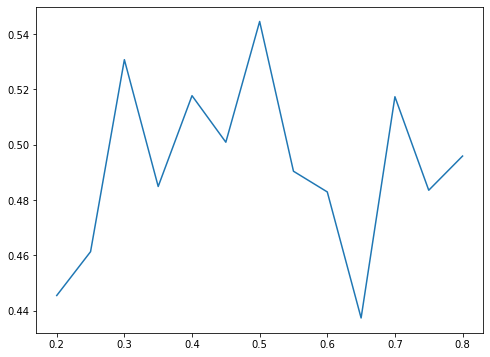

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8,6))
plt.plot(max_dfs,avg_f1s)

In [76]:
#Well, it looks like the basic .5 is the winner.
max_dfs[np.argmax(avg_f1s)]

0.5

In [109]:
#What about regression?
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_absolute_error

In [147]:
master_ratings.dropna(inplace=True)

In [148]:
X_train, X_test, y_train, y_test = train_test_split(master_ratings['item_list'],
                                                    master_ratings['item_rating'])
fitted = count_vectorizer.fit_transform(X_train)
fitted_test = count_vectorizer.transform(X_test)

In [149]:
lin_reg = LinearRegression(n_jobs=-1)
lin_reg.fit(fitted,y_train)
y_pred = lin_reg.predict(fitted_test)
mean_absolute_error(y_test,y_pred)

1.6169680923970164

In [150]:
svr = LinearSVR()
svr.fit(fitted,y_train)
y_pred = svr.predict(fitted_test)
mean_absolute_error(y_test,y_pred)

1.4846084302337164

In [154]:
ridge = Ridge()
ridge.fit(fitted,y_train)
y_pred = ridge.predict(fitted_test)
mean_absolute_error(y_test,y_pred)

1.4691755346774684

It doesn't surprise me that the Ridge, a linear regression with a shrinkage factor, seems to work best, this is in a way a data set with thousands of 'features', namely the counts on all the different words in the corpus. That said, I don't have a good sense for how to tune a ridge regression in this sort of situation... How high should the tuning paramater be? I assume that the individual coefficients are all likely fairly small, since there are so many of them, does that mean a larger cost value makes sense? I'm just going to cycle through a bunch of options and see what the results are like.

In [169]:
alphas = [.5,1,2,5,10,25,50,100,150,200,250,300]
avg_mae = []
for alpha in alphas:
    maes = []
    for n in range(0,10):
        X_train, X_test, y_train, y_test = train_test_split(master_ratings['item_list'],
                                                            master_ratings['item_rating'])
        fitted = count_vectorizer.fit_transform(X_train)
        fitted_test = count_vectorizer.transform(X_test)
        ridge = Ridge(alpha=alpha)
        ridge.fit(fitted,y_train)
        y_pred = ridge.predict(fitted_test)
        maes.append(mean_absolute_error(y_test,y_pred))
    avg_mae.append(np.average(maes))

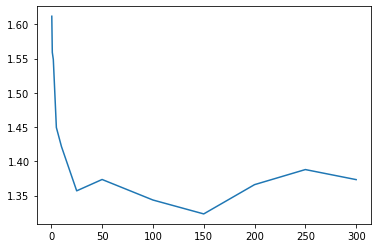

In [170]:
plt.plot(alphas, avg_mae)

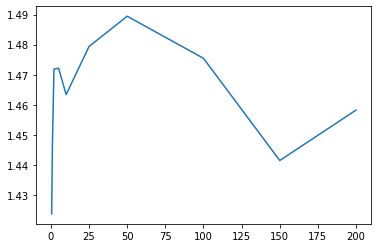

In [166]:
alphas = [.5,1,2,5,10,25,50,100,150,200]
avg_mae = []
for alpha in alphas:
    maes = []
    for n in range(0,10):
        X_train, X_test, y_train, y_test = train_test_split(master_ratings['item_list'],
                                                            master_ratings['item_rating'])
        fitted = count_vectorizer.fit_transform(X_train)
        fitted_test = count_vectorizer.transform(X_test)
        lasso = Lasso(alpha=alpha)
        lasso.fit(fitted,y_train)
        y_pred = lasso.predict(fitted_test)
        maes.append(mean_absolute_error(y_test,y_pred))
    avg_mae.append(np.average(maes))
plt.plot(alphas, avg_mae)

But real benefits come when I tried out the random forest regressor - well, I say real benefits, I mean a reduction of average error something like .1, which is not tremendous, but every little bit helps!

In [194]:
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier

In [199]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
X_train, X_test, y_train, y_test = train_test_split(master_ratings[['instructions','cooking_time',
                                                                    'instructions_lengths']],
                                                    master_ratings['instructions_rating'])
fitted = count_vectorizer.fit_transform(X_train['instructions'])
fitted_test = count_vectorizer.transform(X_test['instructions'])
rfr.fit(fitted,y_train)
y_pred = rfr.predict(fitted_test)
y_train_pred = rfr.predict(fitted)
print(mean_absolute_error(y_test,y_pred))

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1.1479452054794521


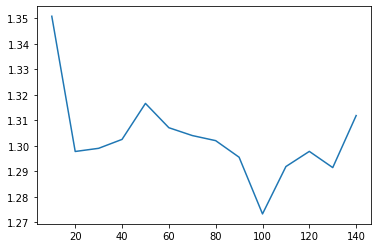

In [200]:
estimators = [x*10 for x in range(1,15)]
avg_maes = []
for estimator in estimators:
    maes=[]
    for n in range(0,20):
        rfr = RandomForestRegressor(n_estimators=estimator,n_jobs=-1)
        X_train, X_test, y_train, y_test = train_test_split(master_ratings['item_list'],
                                                            master_ratings['item_rating'])
        fitted = count_vectorizer.fit_transform(X_train)
        fitted_test = count_vectorizer.transform(X_test)

        rfr.fit(fitted,y_train)
        y_pred = rfr.predict(fitted_test)
        y_train_pred = rfr.predict(fitted)
        maes.append(mean_absolute_error(y_test,y_pred))
    avg_maes.append(np.average(maes))
    
plt.plot(estimators, avg_maes)

It definitely seems like the random forest is the way to go, now the primary question is how do you combine the text with non-text features? One strategy might be to run a model on just the text data and use the output of that model as the input of another model. This is probably the simplest strategy, though it's a little unsatisfying conceptually, and undoubtedly loses a bit of accuracy.

I only have one extra feature for the item list and two for the instructions. Working with the instructions you can see see that this strategy adds some marginal value, though it isn't tremendous.

In [212]:
from sklearn.ensemble import BaggingRegressor
X_train, X_test, y_train, y_test = train_test_split(master_ratings[['instructions','cooking_time',
                                                                    'instructions_lengths']],
                                                    master_ratings['instructions_rating'])
fitted = count_vectorizer.fit_transform(X_train['instructions'])
fitted_test = count_vectorizer.transform(X_test['instructions'])
ridge = Ridge(alpha=150)
ridge.fit(fitted,y_train)
y_pred = ridge.predict(fitted_test)
y_train_pred = ridge.predict(fitted)
print(f'Ridge regression: {mean_absolute_error(y_test,y_pred)}')

X_train['instructions'] = y_train_pred
X_test['instructions'] = y_pred
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print(f'-- Linear Regression:{mean_absolute_error(y_test,y_pred)}')

svr = LinearSVR(max_iter=3000)
svr.fit(X_train,y_train)
y_pred = svr.predict(X_test)
print(f'--SVR: {mean_absolute_error(y_test,y_pred)}')

br = BaggingRegressor()
br.fit(X_train,y_train)
y_pred = br.predict(X_test)
print(f'--Bagged Decision Trees {mean_absolute_error(y_test,y_pred)}')

rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(fitted,y_train)
y_pred = rfr.predict(fitted_test)
y_train_pred = rfr.predict(fitted)
print()
print(f'Random forest regression: {mean_absolute_error(y_test,y_pred)}')
X_train['instructions'] = y_train_pred
X_test['instructions'] = y_pred
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print(f'--Linear Regression: {mean_absolute_error(y_test,y_pred)}')

svr = LinearSVR(max_iter=2500)
svr.fit(X_train,y_train)
y_pred = svr.predict(X_test)
print(f'--SVR: {mean_absolute_error(y_test,y_pred)}')

br = BaggingRegressor()
br.fit(X_train,y_train)
y_pred = br.predict(X_test)
print(f'-- Bagged Decision Trees: {mean_absolute_error(y_test,y_pred)}')

Ridge regression: 1.2052793520247198
-- Linear Regression:1.213725187785147


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


--SVR: 1.9797739949360613
--Bagged Decision Trees 1.1664383561643836

Random forest regression: 1.0663013698630133
--Linear Regression: 1.046570427415283
--SVR: 1.5553025200607478
-- Bagged Decision Trees: 1.021917808219178


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [216]:
from scipy.sparse import hstack
X_train, X_test, y_train, y_test = train_test_split(master_ratings[['instructions','cooking_time',
                                                                    'instructions_lengths']],
                                                    master_ratings['instructions_rating'])
fitted = count_vectorizer.fit_transform(X_train['instructions'])
fitted_test = count_vectorizer.transform(X_test['instructions'])

stacked = hstack([fitted,X_train[['cooking_time','instructions_lengths']]])
stacked_test = hstack([fitted_test,X_test[['cooking_time','instructions_lengths']]])
rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(stacked,y_train)
y_pred = rfr.predict(stacked_test)

print(f'Random forest regression: {mean_absolute_error(y_test,y_pred)}')

Random forest regression: 1.06986301369863


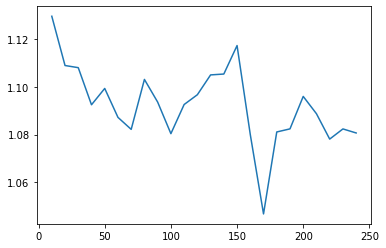

In [217]:
estimators = [x*10 for x in range(1,25)]
avg_maes = []
for estimator in estimators:
    maes=[]
    for n in range(0,20):
        X_train, X_test, y_train, y_test = train_test_split(master_ratings[['instructions','cooking_time',
                                                                    'instructions_lengths']],
                                                            master_ratings['instructions_rating'])
        fitted = count_vectorizer.fit_transform(X_train['instructions'])
        fitted_test = count_vectorizer.transform(X_test['instructions'])
        stacked = hstack([fitted,X_train[['cooking_time','instructions_lengths']]])
        stacked_test = hstack([fitted_test,X_test[['cooking_time','instructions_lengths']]])
        rfr = RandomForestRegressor(n_estimators=estimator,n_jobs=-1)
        rfr.fit(stacked,y_train)
        y_pred = rfr.predict(stacked_test)
        maes.append(mean_absolute_error(y_test,y_pred))
    avg_maes.append(np.average(maes))
plt.plot(estimators, avg_maes)

In [227]:
positives = ['beans','chickpeas','rice','canned','pasta','can','potato','potatoes','carrot','carrots','onion',
             'onions','mushroom','mushrooms','peas','grill','stovetop']

negatives = ['thai','saffron','scallops','tofu','pineapple','banana','cream','mango','avocado','miso','mixer',
             'blender','processor','freezer']
def score(text):
    final_score = 0
    for word in text.split():
        if word in positives:
            final_score +=1
        if word in negatives:
            final_score -= 1
    return final_score

master_ratings['item_dict_rating'] = [score(x) for x in master_ratings['item_list']]
master_ratings['instructions_dict_rating'] = [score(x) for x in master_ratings['instructions']]

In [232]:
maes = []
for n in range(0,20):

    X_train, X_test, y_train, y_test = train_test_split(master_ratings[['instructions','cooking_time',
                                                                        'instructions_lengths',
                                                                        'instructions_dict_rating']],
                                                        master_ratings['instructions_rating'])
    fitted = count_vectorizer.fit_transform(X_train['instructions'])
    fitted_test = count_vectorizer.transform(X_test['instructions'])

    stacked = hstack([fitted,X_train[['cooking_time','instructions_lengths','instructions_dict_rating']]])
    stacked_test = hstack([fitted_test,X_test[['cooking_time','instructions_lengths','instructions_dict_rating']]])
    rfr = RandomForestRegressor(n_estimators=100)
    rfr.fit(stacked,y_train)
    y_pred = rfr.predict(stacked_test)

    maes.append(mean_absolute_error(y_test,y_pred))
    
np.average(maes)

1.091602739726027

In [235]:
maes = []
for n in range(0,20):

    X_train, X_test, y_train, y_test = train_test_split(master_ratings[['item_list','item_lengths',
                                                                        'item_dict_rating']],
                                                        master_ratings['item_rating'])
    fitted = count_vectorizer.fit_transform(X_train['item_list'])
    fitted_test = count_vectorizer.transform(X_test['item_list'])

    stacked = hstack([fitted,X_train[['item_lengths','item_dict_rating']]])
    stacked_test = hstack([fitted_test,X_test[['item_lengths','item_dict_rating']]])
    rfr = RandomForestRegressor(n_estimators=100)
    rfr.fit(stacked,y_train)
    y_pred = rfr.predict(stacked_test)

    maes.append(mean_absolute_error(y_test,y_pred))
    
np.average(maes)

1.2927431506849316

In [ ]:
maes = []
for n in range(0,20):

    X_train, X_test, y_train, y_test = train_test_split(master_ratings[['item_list','item_lengths']],
                                                        master_ratings['item_rating'])
    fitted = count_vectorizer.fit_transform(X_train['item_list'])
    fitted_test = count_vectorizer.transform(X_test['item_list'])

    stacked = hstack([fitted,X_train[['item_lengths']]])
    stacked_test = hstack([fitted_test,X_test[['item_lengths']]])
    rfr = RandomForestRegressor(n_estimators=100)
    rfr.fit(stacked,y_train)
    y_pred = rfr.predict(stacked_test)

    maes.append(mean_absolute_error(y_test,y_pred))
    
np.average(maes)